In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import sys
import torch

from deep_translator import GoogleTranslator
from Levenshtein import distance
from huggingface_hub import HfFolder
from pathlib import Path
from tqdm import tqdm
from transformers import pipeline, set_seed

tqdm.pandas()

# Reproducibility matters
torch.use_deterministic_algorithms(True, warn_only=True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

set_seed(42)

In [ ]:
project_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_path not in sys.path:
  sys.path.insert(0, project_path)

# local imports
from settings import environment
from utils.request import download_mendeley_data, get_readability_metrics
from utils.text import clean_text, remove_punctuation, remove_stopwords

In [4]:
# layout config
sns.set_theme(context='notebook', style='darkgrid')

cmap = 'Blues'
colors = [
    '#56B4E9', '#009E73', '#E69F00', '#F0E442', '#0072B2', '#D55E00', '#CC79A7', '#999999', '#F5C710',
    '#993F88', '#117733', '#44AA99', '#882255', '#661100', '#DDCC77'
]

# Legislative Analysis

## Dataset

Firstly, we download our data:

In [5]:
public_data = Path(f'{environment.BASE_DIR}/data/public_data_en.csv')
if not public_data.is_file():
  download_mendeley_data()

In [6]:
df = pd.read_csv(
  f'{environment.BASE_DIR}/data/public_data_en.csv',
  parse_dates=['proposal_register_date', 'doc_inclusion_date_proposal']
)

In [7]:
df.head(2)

,process_number,process_year,proposal_number,proposal_year,proposal_summary,proposal_register_date,proposal_initiative_description,proposal_initiative_type,proposal_subject_description,proposal_class,doc_id,doc_subject,doc_class,doc_text,doc_inclusion_date_proposal
0,2668,2019,239,2019,"Institui, no âmbito do Estado do R...",2019-08-06,DEP. UBALDO FERNANDES,PARLAMENTAR,Saúde,PROJETO DE LEI,138281,Autógrafo,Autógrafo,"<div class=""ementa-direita"" style=""text-align:...",2023-02-08 13:23:40.280
1,2859,2019,2493,2019,Sessão Solene em Homenagem Ao Dia do Dentista ...,2019-08-20,DEP. SANDRO PIMENTEL,PARLAMENTAR,NaN,REQUERIMENTO,387,Sessão Solene,Requerimento,"<p class=""paragraph-indented"" style=""text-inde...",2019-08-16 12:59:26.000


First impressions:

In [8]:
df.shape

(1869, 15)

In [9]:
df.columns

Index(['process_number', 'process_year', 'proposal_number', 'proposal_year',
       'proposal_summary', 'proposal_register_date',
       'proposal_initiative_description', 'proposal_initiative_type',
       'proposal_subject_description', 'proposal_class', 'doc_id',
       'doc_subject', 'doc_class', 'doc_text', 'doc_inclusion_date_proposal'],
      dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1869 entries, 0 to 1868
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   process_number                   1869 non-null   int64         
 1   process_year                     1869 non-null   int64         
 2   proposal_number                  1869 non-null   int64         
 3   proposal_year                    1869 non-null   int64         
 4   proposal_summary                 1869 non-null   object        
 5   proposal_register_date           1869 non-null   datetime64[ns]
 6   proposal_initiative_description  1869 non-null   object        
 7   proposal_initiative_type         1869 non-null   object        
 8   proposal_subject_description     1799 non-null   object        
 9   proposal_class                   1869 non-null   object        
 10  doc_id                           1869 non-null   int64      

## Exploring the proposals metadata


### Proposal Types

In [11]:
# According to: https://www.congressonacional.leg.br/legislacao-e-publicacoes/glossario-legislativo/
translation_dict = {
    "PROJETO DE LEI": "Bill of Law",
    "PROJETO DE LEI COMPLEMENTAR": "Bill of Supplementary Law",
    "REQUERIMENTO": "Request",
    "PROPOSTA DE EMENDA CONSTITUCIONAL": "Constitutional Amendment Bill",
    "PROJETO DE DECRETO LEGISLATIVO": "Bill of Legislative Decree",
    "PROJETO DE RESOLUÇÃO": "Bill of Resolution",
}

df['proposal_class_en'] = df.proposal_class.map(translation_dict)

Text(0, 0.5, 'Proposal Type')

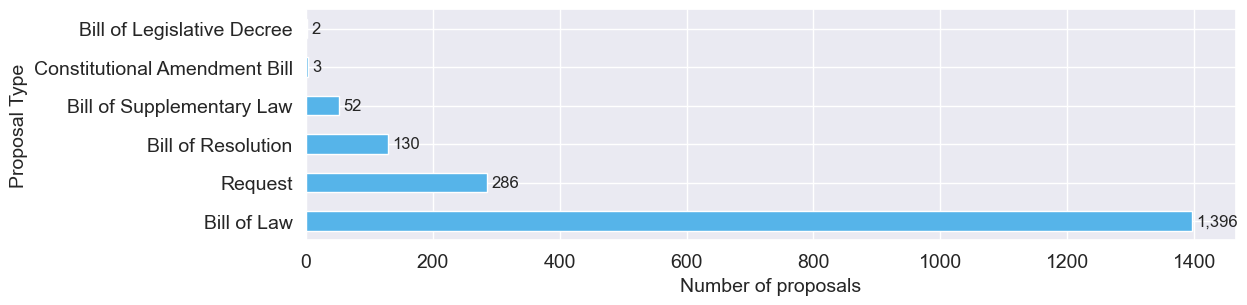

In [12]:
fig, ax = plt.subplots(figsize=(12,3))
df.proposal_class_en.value_counts().plot.barh(color=colors[0], ax=ax, fontsize=14)
ax.bar_label(ax.containers[0], label_type='edge', padding=3, fmt='{:,.0f}')
ax.set_xlabel('Number of proposals', fontsize=14)
ax.set_ylabel('Proposal Type', fontsize=14)

### Proposal thematic areas

In [13]:
translator = GoogleTranslator(source='pt', target='en')
unique_values = df['proposal_subject_description'].unique()
translations = {value: translator.translate(value) if value is not np.nan else value for value in unique_values}
translations['Homenagem'] = 'Tribute'

In [14]:
df['proposal_subject_description_en'] = df.proposal_subject_description.map(translations)

Text(0, 0.5, 'Thematic Area')

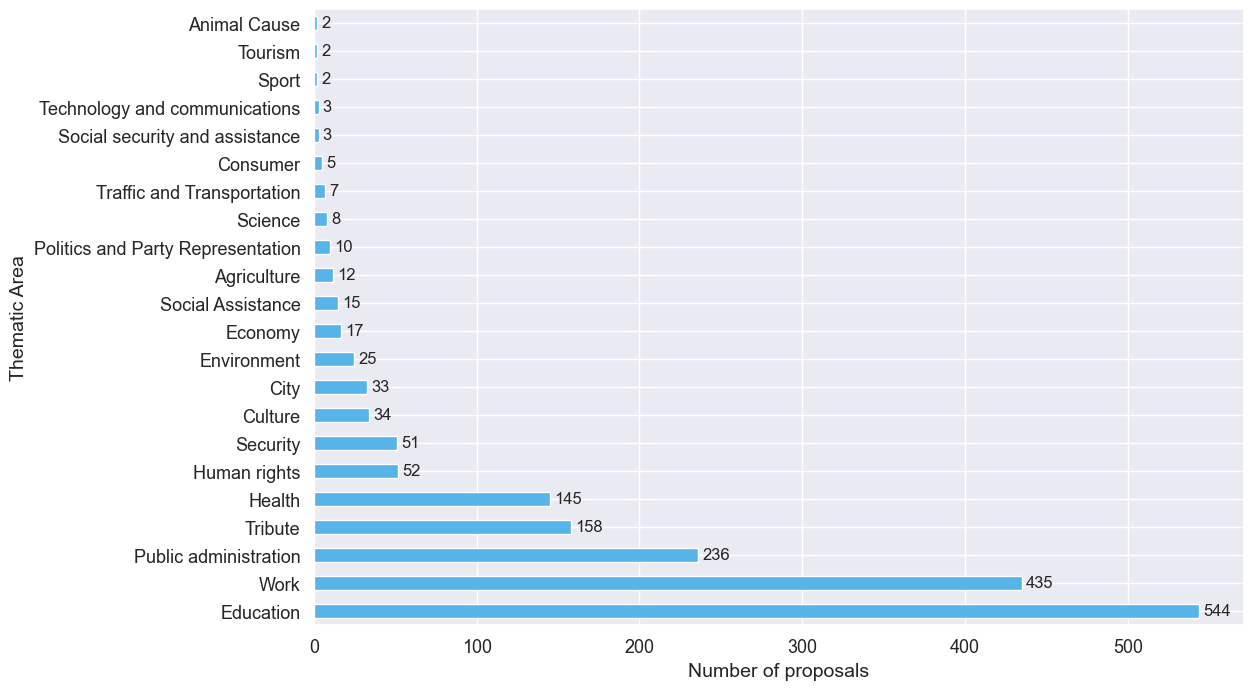

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
resultados = df['proposal_subject_description_en'].value_counts().plot.barh(color=colors[0], ax=ax, fontsize=13)
ax.bar_label(ax.containers[0], label_type='edge', padding=3, fmt='{:,.0f}')
ax.set_xlabel('Number of proposals', fontsize=14)
ax.set_ylabel('Thematic Area', fontsize=14)

### Time

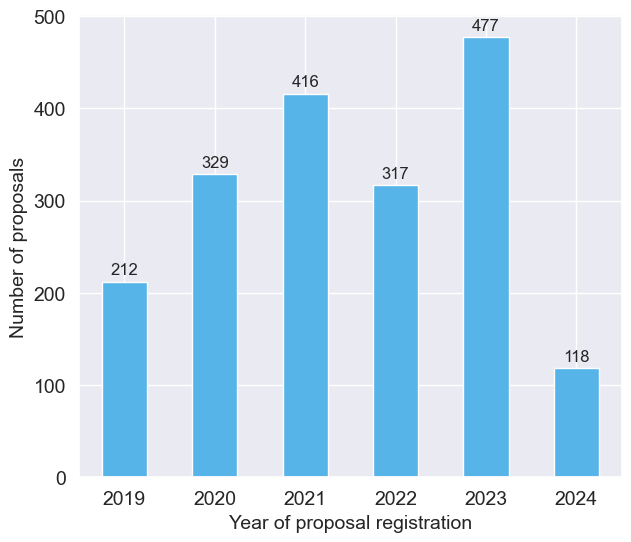

In [16]:
fig, ax = plt.subplots(figsize=(7,6))
df.proposal_register_date.dt.year.value_counts().sort_index().plot.bar(color='#56B4E9', ax=ax, fontsize=14)
ax.bar_label(ax.containers[0], label_type='edge', padding=3)
ax.set_xlabel('Year of proposal registration', fontsize=14)
ax.set_ylabel('Number of proposals', fontsize=14)
ax.xaxis.set_tick_params(rotation=0)

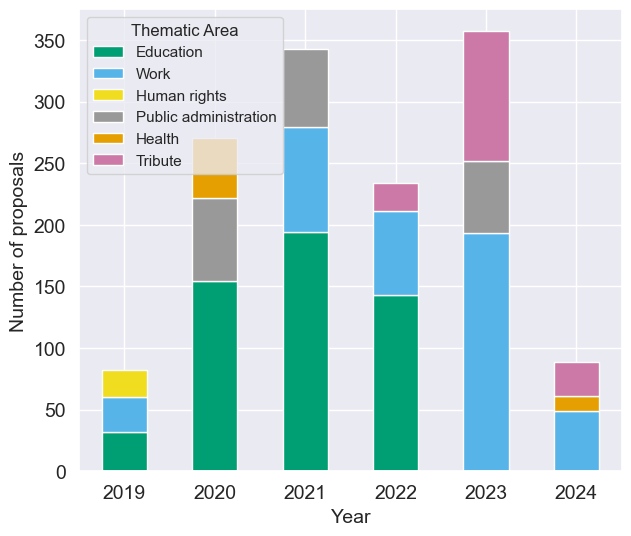

In [17]:
colors = [
    '#CC79A7', '#E69F00', '#999999', '#F1DD20', '#56B4E9', '#009E73'
]

fig, ax = plt.subplots(figsize=(7,6))

by_year = df.groupby([df.proposal_register_date.dt.year, df.proposal_subject_description_en]).doc_id.count().groupby(level=0).nlargest(3).droplevel(0).unstack(fill_value=0)
by_year.plot.bar(ax=ax, stacked=True, color=colors[:9][::-1], fontsize=14)

ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Number of proposals', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
ax.legend(title="Thematic Area", loc="upper left")

## Exploring the text

In [18]:
df['doc_text_clean'] = df['doc_text'].apply(clean_text)
df['doc_text_clean_no_punctuation'] = df['doc_text_clean'].apply(remove_punctuation)

### Analyzing text statistics

Some issues that were found:
- Texts with less than 10 characters
- Files that were unordered, so the first document does not represent the actual proposal 

#### Character

First, let's take a look at the number of characters present in each text.

In [19]:
df['doc_text_clean_no_punctuation'].str.len().describe()

count     1869.000000
mean      2674.835741
std       4941.053324
min        404.000000
25%        737.000000
50%       1552.000000
75%       2803.000000
max      76455.000000
Name: doc_text_clean_no_punctuation, dtype: float64

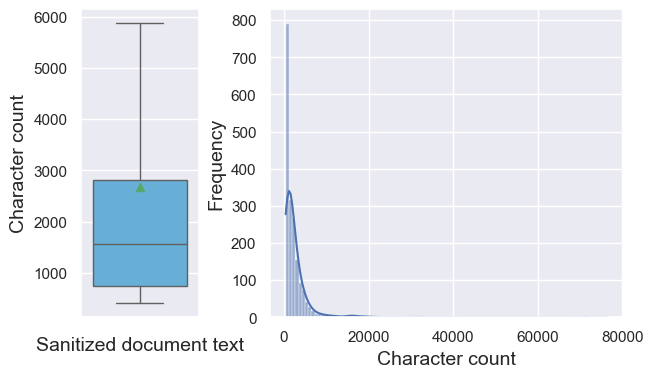

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(7,4), gridspec_kw={'width_ratios': [0.2, 0.6]})
sns.boxplot(data=df['doc_text_clean_no_punctuation'].str.len(), showfliers=False, showmeans=True, color='#56B4E9', ax=axs[0])
sns.histplot(data=df['doc_text_clean_no_punctuation'].str.len(), bins=100, kde=True, ax=axs[1])

axs[0].set_ylabel('Character count', fontsize=14)
axs[0].set_xlabel('Sanitized document text', fontsize=14)
axs[1].set_ylabel('Frequency', fontsize=14)
axs[1].set_xlabel('Character count', fontsize=14)

plt.subplots_adjust(wspace=0.3)

And grouping by the type of process.

In [21]:
df['doc_text_clean_no_punctuation_length'] = df['doc_text_clean_no_punctuation'].str.len()
df.groupby('proposal_class_en')['doc_text_clean_no_punctuation_length'].describe()

,count,mean,std,min,25%,50%,75%,max
proposal_class_en,,,,,,,,
Bill of Law,1396.0,2412.906160,4081.666737,456.0,714.75,1404.5,2807.75,70684.0
Bill of Legislative Decree,2.0,3451.500000,3237.841951,1162.0,2306.75,3451.5,4596.25,5741.0
Bill of Resolution,130.0,4392.207692,8534.708373,772.0,799.50,1621.5,3234.75,71177.0
Bill of Supplementary Law,52.0,9482.500000,13704.968091,695.0,1671.75,3389.5,14313.50,76455.0
Constitutional Amendment Bill,3.0,2620.666667,561.583772,2085.0,2328.50,2572.0,2888.50,3205.0
Request,286.0,1930.101399,1074.354504,404.0,1158.25,1679.0,2455.75,9153.0


C:\Users\gisli\AppData\Local\Temp\ipykernel_20664\681427479.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', fontsize=14)


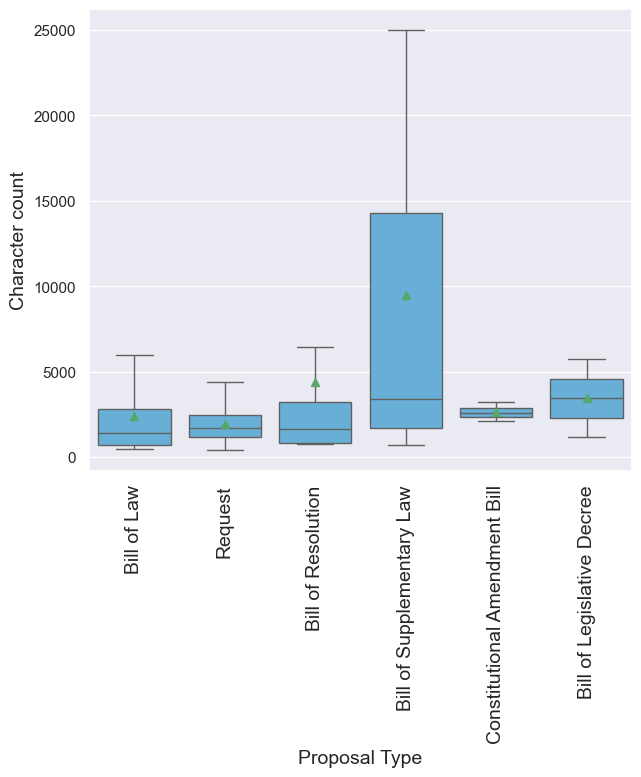

In [22]:
fig, ax = plt.subplots(figsize=(7,6))
sns.boxplot(data=df, x='proposal_class_en', y='doc_text_clean_no_punctuation_length', ax=ax, color='#56B4E9', showfliers=False, showmeans=True)
ax.set(xlabel='Proposal Type', ylabel='Character count')

ax.set_ylabel('Character count', fontsize=14)
ax.set_xlabel('Proposal Type', fontsize=14)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', fontsize=14)
plt.show()

#### Word

Now, we will move on to data exploration at a word-level. Let’s plot the number of words appearing in each text.

In [23]:
words_distribution = df['doc_text_clean_no_punctuation'].str.split().map(lambda x: len(x))
words_distribution.describe()

count     1869.000000
mean       427.440877
std        767.971611
min         64.000000
25%        124.000000
50%        253.000000
75%        457.000000
max      11690.000000
Name: doc_text_clean_no_punctuation, dtype: float64

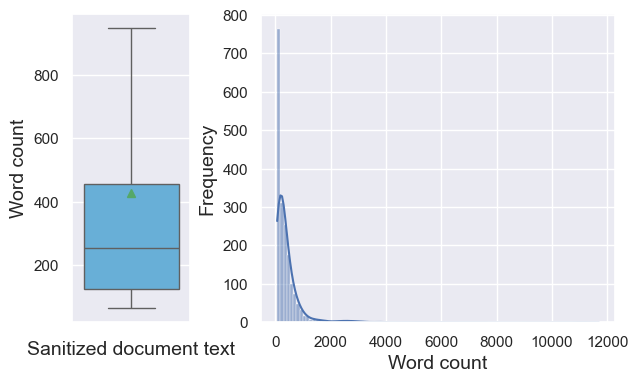

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(7,4), gridspec_kw={'width_ratios': [0.2, 0.6]})
sns.boxplot(data=words_distribution, showfliers=False, showmeans=True, color='#56B4E9', ax=axs[0])
sns.histplot(data=words_distribution, kde=True, ax=axs[1], bins=100)

axs[0].set_ylabel('Word count', fontsize=14)
axs[0].set_xlabel('Sanitized document text', fontsize=14)
axs[1].set_ylabel('Frequency', fontsize=14)
axs[1].set_xlabel('Word count', fontsize=14)

plt.subplots_adjust(wspace=0.3)

Up next, let’s check the average word length in each sentence.

In [25]:
word_avg_len = df['doc_text_clean_no_punctuation'].apply(remove_stopwords).str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))

In [26]:
word_avg_len.describe()

count    1869.000000
mean        6.827724
std         0.498631
min         5.567010
25%         6.421053
50%         6.773723
75%         7.200000
max         8.949275
Name: doc_text_clean_no_punctuation, dtype: float64

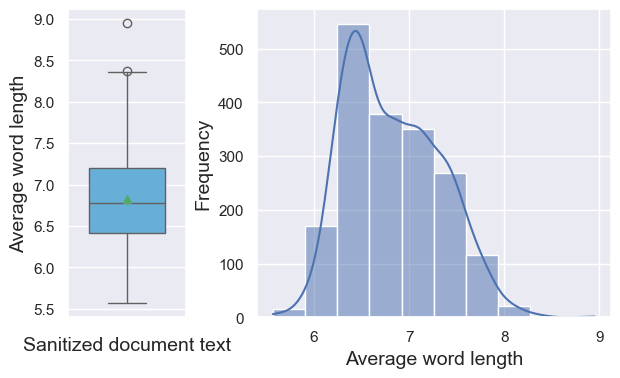

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(7,4), gridspec_kw={'width_ratios': [0.2, 0.6]})
sns.boxplot(data=df, y=word_avg_len, showfliers=True, showmeans=True, color='#56B4E9', ax=axs[0], gap=.2)
sns.histplot(data=df, x=word_avg_len, bins=10, kde=True, ax=axs[1], legend=False)

axs[0].set_ylabel('Average word length', fontsize=14)
axs[0].set_xlabel('Sanitized document text', fontsize=14)
axs[1].set_ylabel('Frequency', fontsize=14)
axs[1].set_xlabel('Average word length', fontsize=14)

plt.subplots_adjust(wspace=0.3)

### Readability Assessment

Readability assessment was carried out using the [NILC-Metrix](http://fw.nilc.icmc.usp.br:23380/nilcmetrix). To use it, follow the steps in [https://github.com/nilc-nlp/nilcmetrix](https://github.com/nilc-nlp/nilcmetrix) to build the containers with NILC-Metrix API and database.

In case you can not perform the mentioned instalation procedure, we provide a dataset with the metrics in `data/readability_public_data`.

Basically, we make requests to an API running in a Docker container, which can return 200 metrics related to textual coherence, cohesion, and readability. We will focus on the readability metrics.

In [28]:
readability_file = Path(f'{environment.BASE_DIR}/data/readability_public_data.csv')
if readability_file.is_file():
  readability_df = pd.read_csv(readability_file, index_col=0)
else:
  readability = df['doc_texto_limpo'].progress_apply(get_readability_metrics)
  readability_df = pd.json_normalize(readability).set_index(readability.index)
  readability_df = df.join(readability_df)
  readability_df.to_csv(readability_file, index=False)

In [29]:
readability_df.shape

(1869, 39)

In [30]:
readability_df[['flesch', 'dalechall_adapted']].describe()

,flesch,dalechall_adapted
count,1869.000000,1869.000000
mean,31.927546,12.401658
std,21.521943,1.150477
min,-577.034930,10.051490
25%,23.281970,11.913670
50%,35.460000,12.301260
75%,43.725130,12.748270
max,69.129430,47.064520


C:\Users\gisli\AppData\Local\Temp\ipykernel_20664\418274463.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=readability_df, x='flesch', kde=True, palette=colors, ax=axs[1], legend=False, bins=100)


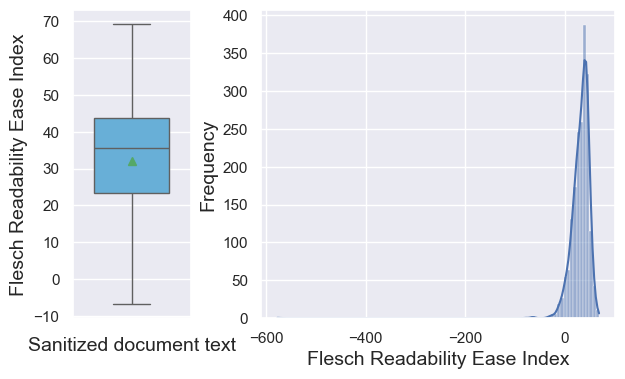

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(7,4), gridspec_kw={'width_ratios': [0.2, 0.6]})

sns.boxplot(data=readability_df, y='flesch', showfliers=False, showmeans=True, color='#56B4E9', ax=axs[0], gap=.2)
sns.histplot(data=readability_df, x='flesch', kde=True, palette=colors, ax=axs[1], legend=False, bins=100)

axs[0].set_ylabel('Flesch Readability Ease Index', fontsize=14)
axs[0].set_xlabel('Sanitized document text', fontsize=14)
axs[1].set_ylabel('Frequency', fontsize=14)
axs[1].set_xlabel('Flesch Readability Ease Index', fontsize=14)

plt.subplots_adjust(wspace=0.3)

C:\Users\gisli\AppData\Local\Temp\ipykernel_20664\2417126395.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=readability_df, x='dalechall_adapted', kde=True, palette=colors, ax=axs[1], legend=False, bins=100)


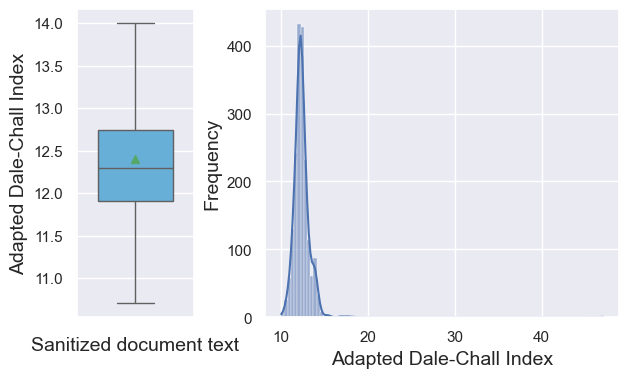

In [32]:
fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(7,4), gridspec_kw={'width_ratios': [0.2, 0.6]})

sns.boxplot(data=readability_df, y='dalechall_adapted', showfliers=False, showmeans=True, color='#56B4E9', ax=axs[0], gap=.2)
sns.histplot(data=readability_df, x='dalechall_adapted', kde=True, palette=colors, ax=axs[1], legend=False, bins=100)

axs[0].set_ylabel('Adapted Dale-Chall Index', fontsize=14)
axs[0].set_xlabel('Sanitized document text', fontsize=14)
axs[1].set_ylabel('Frequency', fontsize=14)
axs[1].set_xlabel('Adapted Dale-Chall Index', fontsize=14)

plt.subplots_adjust(wspace=0.3)

## LLMs to extract KGs

In [33]:
# initial settings
os.environ['HF_HOME'] = f'{environment.BASE_DIR}/models'
os.environ['HUGGINGFACE_TOKEN'] = environment.HUGGING_FACE_TOKEN
os.environ['TRANSFORMERS_CACHE'] = f'{environment.BASE_DIR}/models'
os.environ['HF_DATASETS_CACHE'] = f'{environment.BASE_DIR}/models'

HfFolder.save_token(environment.HUGGING_FACE_TOKEN)

Saving the prompt:

In [34]:
messages = [
  {'role': 'system', 'content': '''
Dado um prompt entre ```, identifique A MAIOR QUANTIDADE possível de entidades e relações entre elas e crie uma lista no formato `[ENTIDADE 1, TIPO ENTIDADE 1, RELAÇÃO, ENTIDADE 2, TIPO ENTIDADE 2]`. Considere os seguintes pontos:
- Os textos informados nos prompts são legislativos e em língua portuguesa. Serão: projetos de lei, decretos, resoluções, requerimentos, emendas, mensagens, ofícios e indicações. Eles podem conter partes repetidas e, nesses casos, use a informação apenas uma vez.
- Use Reconhecimento de Entidades Nomeadas para encontrar as entidades. Mantenha a consistência e use os tipos de entidades "Pessoa", "Organização", "Lei" (leis, decretos, resoluções, emendas, documentos, protocolos) , "Local" (estados, municípios, localidades relevantes), "Tema" (temas ou tópicos, como educação, saúde, emprego), "Ocupação" (cargos ou funções relevantes), "Evento" (Sessões, Audiências, reuniões), "Público-alvo" (categorias ou grupos sociais impactados, como professores, policiais, agricultores), "Produtos_Servicos" (bens ou serviços descritos, regulados ou referenciados, como medicamentos, meios de transporte), "Programa" (para programas e ações em áreas como saúde, educação, segurança) e Tempo (para datas numéricas de publicação, vigência e outros momentos importantes).
- O TIPO ENTIDADE 1 deve ser único para a mesma ENTIDADE 1, consistente em toda a lista. A mesma ideia vale para ENTIDADE 2 e TIPO ENTIDADE 2.
- Em seguida, realize desambiguação de grafia e resolução de co-referência: Para entidades com nomes diferentes ou referenciadas por pronomes, use o identificador mais completo e consistente. Ex.: "José da Silva", "José", "Dr. José", "ele" devem ser substuídos por "José da Silva".
- Faça a Extração das Relações: Busque as relações e ações entre as entidades, que devem ser direcionadas (a ordem importa). Geralmente, serão verbos e as relações devem ser DIRETAS E CURTAS. Inclua verbos ou expressões que indicam iniciativas legislativas, como "revogar", "decretar", "aprovar", "propor".
- Seja extremamente fiel ao texto, não inclua novas informações.

Exemplo:

### Prompt: ```Lei 2.000 de outubro de 2023. Reconhece como utilidade pública o Instituto de Preservação da Fauna e Flora do Nordeste (IPFFN).  
A GOVERNADORA DO ESTADO DO RIO GRANDE DO NORTE: FAÇO SABER que o PODER LEGISLATIVO decreta e EU sanciono a seguinte Lei:  
Reconhece-se como de utilidade pública o Instituto de Preservação da Fauna e Flora do Nordeste (IPFFN), localizado em Natal, Rio Grande do Norte, que promove a conservação ambiental e a educação ecológica.
Este reconhecimento é proposto pelo Deputado João Silva, aprovado na sessão de 15 de março de 2023 pela Comissão de Meio Ambiente.```

### Lista de relações
```array
[
  ["Lei 2.000 de outubro de 2023", "Lei", "RECONHECER", "Instituto de Preservação da Fauna e Flora do Nordeste", "Organização"],
  ["Governadora do Estado do Rio Grande do Norte", "Pessoa", "SANCIONAR", "Lei 2.000 de outubro de 2023", "Lei"],
  ["Poder Legislativo", "Organização", "DECRETAR", "Lei 2.000 de outubro de 2023", "Lei"],
  ["Instituto de Preservação da Fauna e Flora do Nordeste", "Organização", "SER_RECONHECIDO_COMO", "Utilidade Pública", "Tema"],
  ["Instituto de Preservação da Fauna e Flora do Nordeste", "Organização", "LOCALIZADO_EM", "Natal", "Local"],
  ["Instituto de Preservação da Fauna e Flora do Nordeste", "Organização", "PROMOVER", "Conservação Ambiental", "Tema"],
  ["Instituto de Preservação da Fauna e Flora do Nordeste", "Organização", "PROMOVER", "Educação Ecológica", "Tema"],
  ["Deputado João Silva", "Pessoa", "PROPOR", "Reconhecimento", "Lei"],
  ["Reconhecimento", "Lei", "APROVADO_EM", "15 de março de 2023", "Tempo"],
  ["Reconhecimento", "Lei", "APROVADO_POR", "Comissão de Meio Ambiente", "Organização"],
  ["Natal", "Local", "PERTENCE_A", "Rio Grande do Norte", "Local"]
]
```

Lembre-se que é EXTREMAMENTE IMPORTANTE capturar a MAIOR QUANTIDADE de entidades e relações.
'''}
]

Selected examples:

In [35]:
# Honorary Title of Citizen of Rio Grande do Norte
bill_of_resolution = df[((df.process_number == 2728) & (df.process_year == 2019))]['doc_text_clean'].iloc[0]

# Preventive Dentistry Program
bill_of_law = df[((df.process_number == 709) & (df.process_year == 2024))]['doc_text_clean'].iloc[0]

### Llama 3.2 Instruct

Loading the model:

In [37]:
model_id = 'meta-llama/Llama-3.2-3B-Instruct'
pipe = pipeline(
  'text-generation',
  model=model_id,
  torch_dtype=torch.float16,
  device_map='auto'
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


Performing the inference:

In [38]:
# bill of law
messages.append({'role': 'user', 'content': f'```{bill_of_law}```'})
outputs = pipe(
  messages,
  max_new_tokens=60000,
)

str_output_law = outputs[0]["generated_text"][-1]

In [ ]:
str_output_law

{'role': 'assistant',
 'content': '### Lista de relações\n\n```array\n[\n  ["Programa SORRISO POPE", "Programa", "INSTITUI", "Escolas Estaduais do Estado do Rio Grande do Norte", "Local"],\n  ["Governadora do Estado do Rio Grande do Norte", "Pessoa", "FAÇO_SABER", "Programa SORRISO POPE", "Programa"],\n  ["Poder Legislativo", "Organização", "DECRETAR", "Programa SORRISO POPE", "Programa"],\n  ["Programa SORRISO POPE", "Programa", "TER_Público Alvo", "Alunos do 1º ano ensino fundamental até o 3º ano do ensino médio", "Público-alvo"],\n  ["Secretaria de Estado de Saúde", "Organização", "IMPLEMENTAR", "Programa SORRISO POPE", "Programa"],\n  ["Secretaria de Educação", "Organização", "IMPLEMENTAR", "Programa SORRISO POPE", "Programa"],\n  ["Programa SORRISO POPE", "Programa", "DESENVOLVER_AÇÕES", "Unidades de Ensino", "Evento"],\n  ["Programa SORRISO POPE", "Programa", "DESENVOLVER_AÇÕES", "Palestras", "Evento"],\n  ["Programa SORRISO POPE", "Programa", "DESENVOLVER_AÇÕES", "Debates", "Eve

In [ ]:
# bill of resolution
messages[1] = {'role': 'user', 'content': f'```{bill_of_resolution}```'}
outputs = pipe(
    messages,
    max_new_tokens=60000,
)
str_output_resolution = outputs[0]["generated_text"][-1]

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In [ ]:
str_output_resolution

{'role': 'assistant',
 'content': '### Lista de relações\n\n```array\n[\n  ["Título Honorífico de Cidadão Norte-rio-grandense", "Título Honorífico", "CONCEDER", "Antônio Geraldo da Silva", "Pessoa"],\n  ["Presidente da Assembleia Legislativa do Estado do Rio Grande do Norte", "Pessoa", "FAÇO_SABER", "Título Honorífico de Cidadão Norte-rio-grandense", "Título Honorífico"],\n  ["Poder Legislativo", "Organização", "APROVOU", "Título Honorífico de Cidadão Norte-rio-grandense", "Título Honorífico"],\n  ["Lei", "Lei", "PROMULGAR", "Título Honorífico de Cidadão Norte-rio-grandense", "Título Honorífico"],\n  ["Assembleia Legislativa do Estado do Rio Grande do Norte", "Organização", "APROVOU", "Título Honorífico de Cidadão Norte-rio-grandense", "Título Honorífico"],\n  ["Deputado Hermano Morais", "Pessoa", "JUSTIFICATIVO", "Antônio Geraldo da Silva", "Pessoa"],\n  ["Dr. Antônio Geraldo da Silva", "Pessoa", "É", "Médico Psiquiatra", "Ocupação"],\n  ["Dr. Antônio Geraldo da Silva", "Pessoa", "NAS

In [41]:
torch.cuda.empty_cache()
torch.cuda.synchronize()
torch.cuda.reset_peak_memory_stats()
gc.collect()

20

## PostProcessing

The first step is to convert the string from the Llama output into a Python list formated as `[ENTIDADE 1, TIPO ENTIDADE 1, RELAÇÃO, ENTIDADE 2, TIPO ENTIDADE 2]`:

In [ ]:
def convert_str_to_list(text: str):
  search = 'array\n'
  position = text.find(search)
  if position != -1:
    result = text[position + len(search):]
    result = result.replace('\n', '').replace('```', '').strip()
    return json.loads(result)

In [ ]:
array_law = convert_str_to_list(str_output_law['content'])
array_resolution = convert_str_to_list(str_output_resolution['content'])

After that, we perform a simple entity disambiguation based on Levenshtein distance:

In [ ]:
def compare_nodes(node1, node2):
  if node1 in node2 and distance(node1, node2) < 5 and node1 != node2:
    return node2
  return node1

def run_entity_disambiguation(lists):
  for i, r_list in enumerate(lists):
    for l_list in lists:
      r_list[0] = compare_nodes(r_list[0], r_list[3])
      r_list[0] = compare_nodes(r_list[0], l_list[0])
      r_list[0] = compare_nodes(r_list[0], l_list[3])

      r_list[3] = compare_nodes(r_list[3], r_list[0])
      r_list[3] = compare_nodes(r_list[3], l_list[0])
      r_list[3] = compare_nodes(r_list[3], l_list[3])
      lists[i] = r_list

In [ ]:
run_entity_disambiguation(array_law)
run_entity_disambiguation(array_resolution)

### Generating Neo4j Code

Now, we create the code:

In [ ]:
def format_node_labels(label):
  return re.sub(r'[\s\-_]+', ' ', label).title().replace(' ', '')

def generate_cypher(data):
  commands = ''
  index = 0
  for i, r_list in enumerate(data):
    commands += f'MERGE (v{index}:{format_node_labels(r_list[1])} {{nome: "{r_list[0]}"}})\n'
    index += 1

    commands += f'MERGE (v{index}:{format_node_labels(r_list[4])} {{nome: "{r_list[3]}"}})\n'
    index += 1

    commands += f'MERGE (v{index-2})-[:{r_list[2].replace(' ', '_').upper()}]->(v{index-1})\n'
  return commands

In [ ]:
print(generate_cypher(array_law))

MERGE (v0:Programa {nome: "Programa SORRISO POPE"})
MERGE (v1:Local {nome: "Escolas Estaduais do Estado do Rio Grande do Norte"})
MERGE (v0)-[:INSTITUI]->(v1)
MERGE (v2:Pessoa {nome: "Governadora do Estado do Rio Grande do Norte"})
MERGE (v3:Programa {nome: "Programa SORRISO POPE"})
MERGE (v2)-[:FAÇO_SABER]->(v3)
MERGE (v4:Organização {nome: "Poder Legislativo"})
MERGE (v5:Programa {nome: "Programa SORRISO POPE"})
MERGE (v4)-[:DECRETAR]->(v5)
MERGE (v6:Programa {nome: "Programa SORRISO POPE"})
MERGE (v7:PúblicoAlvo {nome: "Alunos do 1º ano ensino fundamental até o 3º ano do ensino médio"})
MERGE (v6)-[:TER_PÚBLICO_ALVO]->(v7)
MERGE (v8:Organização {nome: "Secretaria de Estado de Saúde"})
MERGE (v9:Programa {nome: "Programa SORRISO POPE"})
MERGE (v8)-[:IMPLEMENTAR]->(v9)
MERGE (v10:Organização {nome: "Secretaria de Educação"})
MERGE (v11:Programa {nome: "Programa SORRISO POPE"})
MERGE (v10)-[:IMPLEMENTAR]->(v11)
MERGE (v12:Programa {nome: "Programa SORRISO POPE"})
MERGE (v13:Evento {nom

In [ ]:
print(generate_cypher(array_resolution))

'MERGE (v0:TítuloHonorífico {nome: "Título Honorífico de Cidadão Norte-rio-grandense"})\nMERGE (v1:Pessoa {nome: "Dr. Antônio Geraldo da Silva"})\nMERGE (v0)-[:CONCEDER]->(v1)\nMERGE (v2:Pessoa {nome: "Presidente da Assembleia Legislativa do Estado do Rio Grande do Norte"})\nMERGE (v3:TítuloHonorífico {nome: "Título Honorífico de Cidadão Norte-rio-grandense"})\nMERGE (v2)-[:FAÇO_SABER]->(v3)\nMERGE (v4:Organização {nome: "Poder Legislativo"})\nMERGE (v5:TítuloHonorífico {nome: "Título Honorífico de Cidadão Norte-rio-grandense"})\nMERGE (v4)-[:APROVOU]->(v5)\nMERGE (v6:Lei {nome: "Lei"})\nMERGE (v7:TítuloHonorífico {nome: "Título Honorífico de Cidadão Norte-rio-grandense"})\nMERGE (v6)-[:PROMULGAR]->(v7)\nMERGE (v8:Organização {nome: "Assembleia Legislativa do Estado do Rio Grande do Norte"})\nMERGE (v9:TítuloHonorífico {nome: "Título Honorífico de Cidadão Norte-rio-grandense"})\nMERGE (v8)-[:APROVOU]->(v9)\nMERGE (v10:Pessoa {nome: "Deputado Hermano Morais"})\nMERGE (v11:Pessoa {nome: 

You can run this code in Neo4j and see the resulting graphs. The Figures in the paper were obtained from Neo4j vizualization and they are available in the `images` folder.